In [1]:
import json
import os
import random
from datetime import datetime, timedelta

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, confusion_matrix, log_loss, precision_recall_curve
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

pd.options.mode.chained_assignment = None

# load data

In [2]:
x_train = pd.read_parquet(
    "../data/selected_features_classification/x_train/data.parquet"
)
x_cv = pd.read_parquet("../data/selected_features_classification/x_cv/data.parquet")
x_test = pd.read_parquet("../data/selected_features_classification/x_test/data.parquet")

In [3]:
y_train = pd.read_parquet(
    "../data/selected_features_classification/y_train/data.parquet"
)["Churn"]
y_cv = pd.read_parquet("../data/selected_features_classification/y_cv/data.parquet")[
    "Churn"
]
y_test = pd.read_parquet(
    "../data/selected_features_classification/y_test/data.parquet"
)["Churn"]

In [4]:
x_train = pd.concat([x_train, x_cv])
y_train = pd.concat([y_train, y_cv])

# Evaluation setup

<img src="https://www.mdpi.com/technologies/technologies-09-00081/article_deploy/html/images/technologies-09-00081-g001.png" width="800" height="400">

1. We need to boost values of diagonal elements in the confusion matrix
1. In order to monitor the performance of our models we can create Precision Recall Matrices
1. Where in we divide Confusion matrix by
    - sum of confusion matrix across rows -> to get Precision matrix
    - sum of confusion matrix across columns -> to get Recall matrix

# Precision recall matrix

In [5]:
np.seterr(divide="ignore", invalid="ignore")


def get_pr_matrix(y_true, y_pred):
    """
    Get precision recall matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    # avoid nans in matrix, replace with 0
    pr_matrix = cm / cm.sum(axis=0)
    pr_matrix = np.nan_to_num(pr_matrix)
    re_matrix = (cm.T / cm.sum(axis=1)).T
    re_matrix = np.nan_to_num(re_matrix)

    return pr_matrix, re_matrix


def plot_matrix_heatmap(mat, labels=[0, 1], title="None"):
    plt.figure(figsize=(3, 2), dpi=140)
    plt.title(title)
    cmap = sns.light_palette("green")
    sns.heatmap(
        mat, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels,
    )
    plt.xlabel("Predicted Class")
    plt.ylabel("Original Class")
    plt.show()


def plot_pr_matrix_heatmaps(y_true, y_pred):
    p, r = get_pr_matrix(y_true, y_pred)

    plot_matrix_heatmap(p, title="Precision Matrix")
    plot_matrix_heatmap(r, title="Recall Matrix")

# Random model

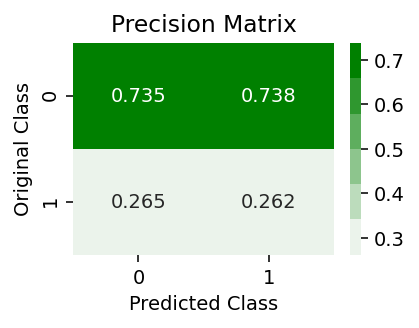

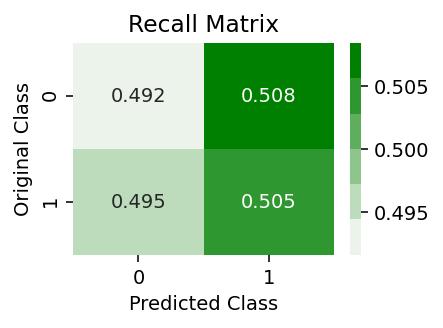


log loss of random model on train set : 0.9832961054753049


In [6]:
random_pred = np.random.randint(low=0, high=2, size=x_train.shape[0])
random_pred_proba = np.random.random(size=x_train.shape[0])


plot_pr_matrix_heatmaps(y_train, random_pred)

ll_random_train = log_loss(y_train, random_pred_proba)
print(f"\nlog loss of random model on train set : {ll_random_train}")

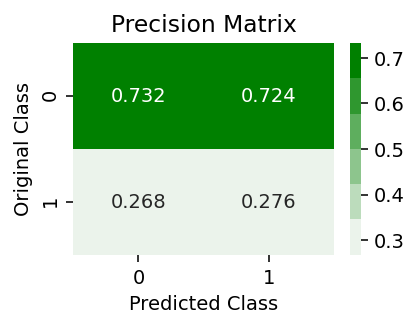

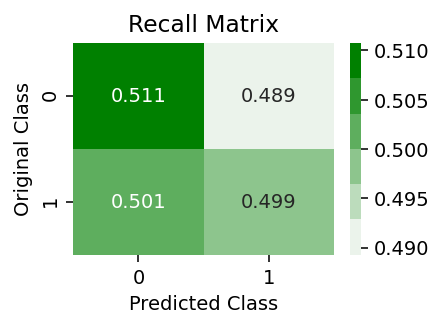


log loss of random model on test set : 0.9491220484185569


In [7]:
random_pred = np.random.randint(low=0, high=2, size=x_test.shape[0])
random_pred_proba = np.random.random(size=x_test.shape[0])


plot_pr_matrix_heatmaps(y_test, random_pred)

ll_random_train = log_loss(y_test, random_pred_proba)
print(f"\nlog loss of random model on test set : {ll_random_train}")

- A model with perfect skill is depicted as a point at a coordinate of (1,1). A skillful model is represented by a curve that bows towards a coordinate of (1,1). 
- A no-skill classifier will be a horizontal line on the plot with a precision that is proportional to the number of positive examples in the dataset. For a balanced dataset this will be 0.5.
- The focus of the PR curve on the minority class makes it an effective diagnostic for imbalanced binary classification models.


[reference](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/) 


## Observations on performance of random classifier

Precision recall matrix (PR matrix)
1. We can see that Recall is randomly getting distributed in each classification and misclassification
1. Whereas precision is getting distributed in a proportionate format based on the imbalance in the dataset

---

Log loss
1. log_loss on train set test set are very close to 1.0
1. Our machine learning model should give log loss that is at least better than this log loss



# Class weights

Handle imbalance in labels

In [8]:
def get_class_weights(y, classes=[0, 1]):
    """
    for "balanced" 
    w = n_samples / (n_classes * np.bincount(y))
    """

    w = compute_class_weight("balanced", classes=classes, y=y,)
    class_weights = {i: j for i, j in zip(classes, w)}

    return class_weights


# demo
get_class_weights(y_train, classes=[0, 1])

{0: 0.679122468659595, 1: 1.895693135935397}

# Time series split

In [9]:
x_train.columns

Index(['TotalCharges', 'MonthlyCharges', 'Contract_0', 'cos_day', 'sin_day',
       'TechSupport_0'],
      dtype='object')

In [10]:
tscv = TimeSeriesSplit(n_splits=10)
tscv

TimeSeriesSplit(max_train_size=None, n_splits=10)

# Training Random Forest Model

## tuning num_estimators

In [12]:
num_estimators_list = [20, 30, 40, 50, 60, 70, 100, 150, 200, 250, 300, 400, 450, 500]

tscv_loss_dict = {}
for ix, ne in enumerate(num_estimators_list):
    print(f"num_estimators {ne}")

    tscv_loss_list = []

    for train_index, cv_index in tscv.split(x_train):

        # get data for cv ready
        x_train_req = x_train.iloc[train_index]
        x_cv_req = x_train.iloc[cv_index]

        y_train_req = y_train.iloc[train_index]
        y_cv_req = y_train.iloc[cv_index]

        # get class weights
        class_weights = get_class_weights(y_train[train_index], classes=[0, 1])

        # print(f"len_train {len(train_index)}, len_cv {len(cv_index)}")
        clf = RandomForestClassifier(n_estimators=ne, class_weight=class_weights)
        clf.fit(x_train_req, y_train_req)

        # get log los train
        y_pred_train_ll = clf.predict_proba(x_train_req)
        ll_train = log_loss(y_train_req, y_pred_train_ll)

        # get log los cv set
        y_pred_val_ll = clf.predict_proba(x_cv_req)
        ll_cv = log_loss(y_cv_req, y_pred_val_ll)

        tscv_loss_list.append({"ll_train": ll_train, "ll_cv": ll_cv})

    tscv_loss_dict[ix] = tscv_loss_list

num_estimators 20
num_estimators 30
num_estimators 40
num_estimators 50
num_estimators 60
num_estimators 70
num_estimators 100
num_estimators 150
num_estimators 200
num_estimators 250
num_estimators 300
num_estimators 400
num_estimators 450
num_estimators 500


In [13]:
df_tscv = pd.DataFrame(tscv_loss_dict.items()).rename(
    columns={0: "iteration", 1: "losses"}
)

df_tscv["ll_train"] = df_tscv["losses"].apply(
    lambda x: np.mean([i["ll_train"] for i in x])
)
df_tscv["ll_cv"] = df_tscv["losses"].apply(lambda x: np.mean([i["ll_cv"] for i in x]))


df_tscv["num_estimators"] = num_estimators_list
df_tscv = df_tscv.drop(columns=["losses"])
df_tscv

,iteration,ll_train,ll_cv,num_estimators
0,0,0.115766,0.904358,20
1,1,0.113808,0.792146,30
2,2,0.113740,0.745538,40
3,3,0.112702,0.687877,50
4,4,0.112871,0.623019,60
5,5,0.113163,0.638948,70
6,6,0.112562,0.591986,100
7,7,0.112062,0.569706,150
8,8,0.112125,0.545029,200
9,9,0.112043,0.544944,250


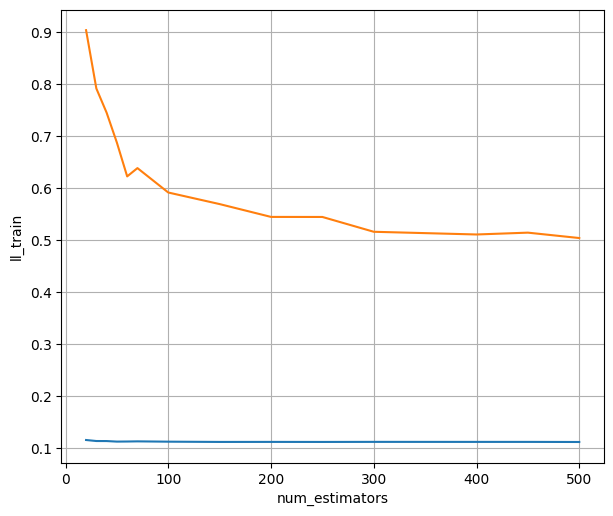

In [14]:
plt.figure(figsize=[7, 6], dpi=100)
sns.lineplot(y="ll_train", x="num_estimators", data=df_tscv)
sns.lineplot(y="ll_cv", x="num_estimators", data=df_tscv)
plt.grid()

Using `n_estimators = 250` as best param

## re-train with best num_estimators

In [18]:
x_train = pd.read_parquet(
    "../data/selected_features_classification/x_train/data.parquet"
)
x_cv = pd.read_parquet("../data/selected_features_classification/x_cv/data.parquet")
x_test = pd.read_parquet("../data/selected_features_classification/x_test/data.parquet")

y_train = pd.read_parquet(
    "../data/selected_features_classification/y_train/data.parquet"
)["Churn"]
y_cv = pd.read_parquet("../data/selected_features_classification/y_cv/data.parquet")[
    "Churn"
]
y_test = pd.read_parquet(
    "../data/selected_features_classification/y_test/data.parquet"
)["Churn"]

x_train = pd.concat([x_train, x_cv])
y_train = pd.concat([y_train, y_cv])

In [19]:
clf = RandomForestClassifier(n_estimators=250)
clf.fit(x_train, y_train)

y_pred_train = clf.predict(x_train)
y_pred_test = clf.predict(x_test)

y_pred_proba_train = clf.predict_proba(x_train)
y_pred_proba_test = clf.predict_proba(x_test)

## Check log loss

In [20]:
log_loss_train = log_loss(y_train, y_pred_proba_train)
log_loss_test = log_loss(y_test, y_pred_proba_test)

print(f"log loss train {log_loss_train}")
print(f"log loss test {log_loss_test}")

log loss train 0.11384032771799346
log loss test 0.5404848995450136


## Check PR matrix

### Train set

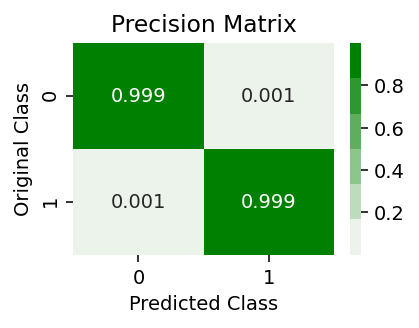

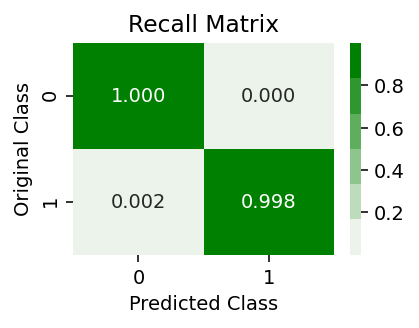

In [21]:
plot_pr_matrix_heatmaps(y_train, y_pred_train)

1. We can see that  model is performing very well on training data
1. Precision and recall matrix diagonals are very close to 1

### Test set

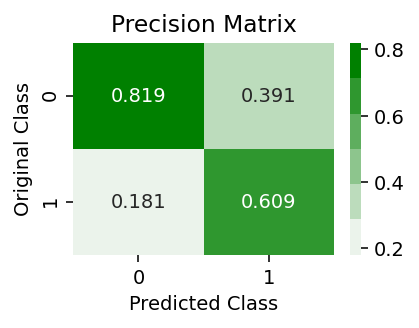

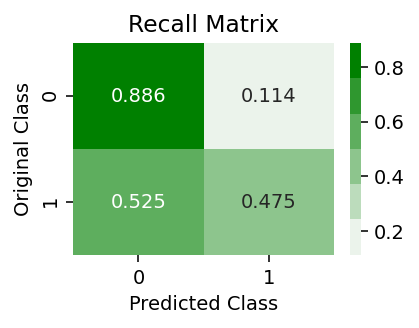

In [22]:
plot_pr_matrix_heatmaps(y_test, y_pred_test)

1. We can see that model has poorly performed on test set
1. Due to imbalance in data more number of 0 labels as compared to 1s

1. In precision matrix we can see that 
    1. only 69% of predicted positives actually belonged to same class
    1. only 81% pf predicted negatives actually belonged to the same class
1. In recall matrix we can see that 
    1. 47.5% of actual positive labels are being predicted as positives
    1. Similarly 88% of actual negatives are being predicted as negatives

# Fine tuning Random Forest Model

In [104]:
# using best n_estimators got from training

class_weight = get_class_weights(y_train)
clf = RandomForestClassifier(n_estimators=250, class_weight=class_weight)


param_grid = {
    "max_depth": [100, 200, 300, None],
    "min_samples_split": [2, 3, 4],
    "criterion": ["gini"],
}

grid_search_clf = GridSearchCV(
    estimator=clf, param_grid=param_grid, cv=None, refit=True, scoring="neg_log_loss"
)
grid_search_clf.fit(x_train, y_train)

%time

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.81 µs


In [105]:
grid_search_clf.best_estimator_

RandomForestClassifier(class_weight={0: 0.679122468659595,
                                     1: 1.895693135935397},
                       max_depth=200, min_samples_split=3, n_estimators=250)

In [106]:
y_pred_train = grid_search_clf.predict(x_train)
y_pred_test = grid_search_clf.predict(x_test)

y_pred_proba_train = grid_search_clf.predict_proba(x_train)
y_pred_proba_test = grid_search_clf.predict_proba(x_test)

## Check log loss

In [107]:
log_loss_train = log_loss(y_train, y_pred_proba_train)
log_loss_test = log_loss(y_test, y_pred_proba_test)

print(f"log loss train {log_loss_train}")
print(f"log loss test {log_loss_test}")

log loss train 0.14192952923966556
log loss test 0.5237680879260881


## Check PR matrix

### Train set

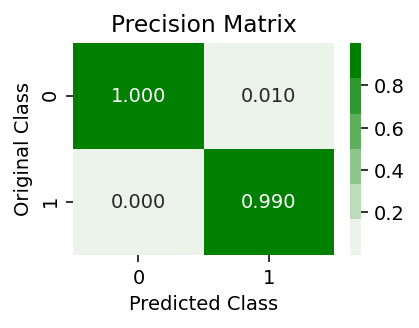

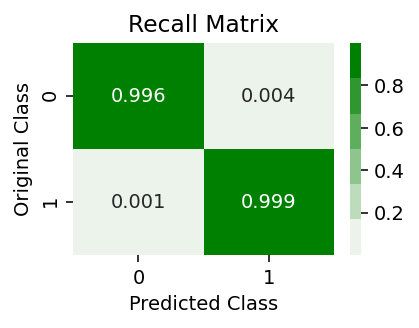

In [108]:
plot_pr_matrix_heatmaps(y_train, y_pred_train)

### Test set

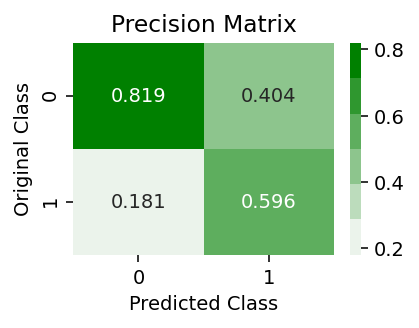

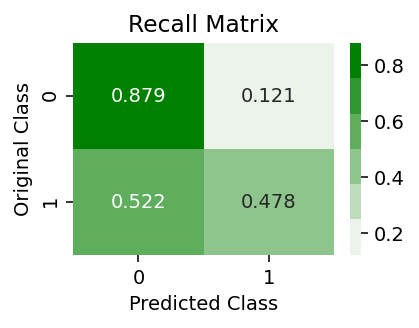

In [109]:
plot_pr_matrix_heatmaps(y_test, y_pred_test)

1. We can see that model has poorly performed on test set even after fine tuning
1. In precision matrix we can see that 
    1. only 60% of predicted positives actually belonged to same class
    1. only 81% pf predicted negatives actually belonged to the same class
1. In recall matrix we can see that 
    1. 47.8% of actual positive labels are being predicted as positives
    1. Similarly ~88% of actual negatives are being predicted as negatives

There is no drastic improvement seen after fine tuning the model with above mentioned params.

# Save model

In [125]:
os.makedirs("../data/models/clf/random_forest/", exist_ok=True)

In [127]:
joblib.dump(
    grid_search_clf.best_estimator_, "../data/models/clf/random_forest/rf_model.pkl"
)

['rf_model.pkl']